# **Problema 2 - Fruits and Vegetables Recognizer:**

## Librerías:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import os
import shutil
import random
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from termcolor import colored
from tensorflow.keras.applications import MobileNetV2, VGG16, ResNet50
from tensorflow.keras import models, optimizers
import cv2

### Dividir imágenes en carpetas para train (80%), test (10%) y validation (10%)

In [ ]:
def split_data(source_dir, train_dir, val_dir, test_dir, train_split=0.8, val_split=0.1):
    all_images = os.listdir(source_dir)
    random.shuffle(all_images)  # Shuffle images for random splitting

    train_size = int(len(all_images) * train_split)
    val_size = int(len(all_images) * val_split)

    # Ensure directories exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Move images to training set
    for img in all_images[:train_size]:
        shutil.copy(os.path.join(source_dir, img), os.path.join(train_dir, img))

    # Move images to validation set
    for img in all_images[train_size:train_size + val_size]:
        shutil.copy(os.path.join(source_dir, img), os.path.join(val_dir, img))

    # Move images to test set
    for img in all_images[train_size + val_size:]:
        shutil.copy(os.path.join(source_dir, img), os.path.join(test_dir, img))

In [ ]:
def process_data(source_dir, train_set_path, val_set_path, test_set_path):
    # Process all items in source directory
    for category in os.listdir(source_dir):
        category_dir = os.path.join(source_dir, category)
        train_dir = os.path.join(train_set_path, category)
        val_dir = os.path.join(val_set_path, category)
        test_dir = os.path.join(test_set_path, category)
        split_data(category_dir, train_dir, val_dir, test_dir)

In [1]:
# Set the paths for datasets
data_source_path = r'Datasets_P2/Fruits_Vegetables_Dataset'
train_set_path = r'Datasets_P2/Fruits_Vegetables_Dataset/train_set'
val_set_path = r'Datasets_P2/Fruits_Vegetables_Dataset/val_set'
test_set_path = r'Datasets_P2/Fruits_Vegetables_Dataset/test_set'

In [ ]:
process_data(data_source_path, train_set_path, val_set_path, test_set_path)

In [3]:
def num_of_classes(folder_dir, folder_name) :
    classes = [class_name for class_name in os.listdir(train_set_path)]
    print(colored(f'Número de clases en {folder_name} folder : {len(classes)}', 'black', attrs=['bold']))

### Conteo de datos y clases

In [4]:
num_of_classes(train_set_path, 'train')
num_of_classes(val_set_path, 'validation')
num_of_classes(test_set_path, 'test')

Número de clases en train folder : 6
Número de clases en validation folder : 6
Número de clases en test folder : 6


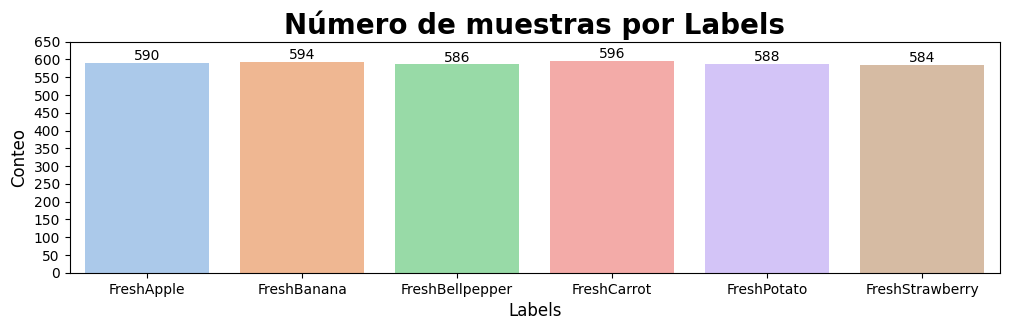

In [6]:
classes = [class_name for class_name in os.listdir(train_set_path)]
count = []
for class_name in classes:
    count.append(len(os.listdir(os.path.join(train_set_path, class_name))))

colors = sns.color_palette("pastel", len(classes))

plt.figure(figsize=(12, 3))
ax = sns.barplot(x=classes, y=count, hue=classes, palette=colors, legend=False)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Número de muestras por Labels', fontsize=20, fontweight='bold')
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Conteo', fontsize=12)
plt.yticks(np.arange(0, 700, 50))
plt.show()

### Cargar y convertir data

In [124]:
def load_data(path):
    data = []
    for category in os.listdir(path):
        category_path = os.path.join(path, category)
        for image_name in os.listdir(category_path):
            img_path = os.path.join(category_path, image_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))  
                data.append([img, category])
    df = pd.DataFrame(data, columns=['image', 'label'])
    return df

In [125]:
train_df = load_data(train_set_path)
val_df = load_data(val_set_path)
test_df = load_data(test_set_path)

In [126]:
print(f'Número de muestras en train: {train_df.shape[0]}')
print(f'Número de muestras en validation: {val_df.shape[0]}')
print(f'Número de muestras en test: {test_df.shape[0]}')

Número de muestras en train: 3538
Número de muestras en validation: 690
Número de muestras en test: 711


### Mostrar imagen por clase

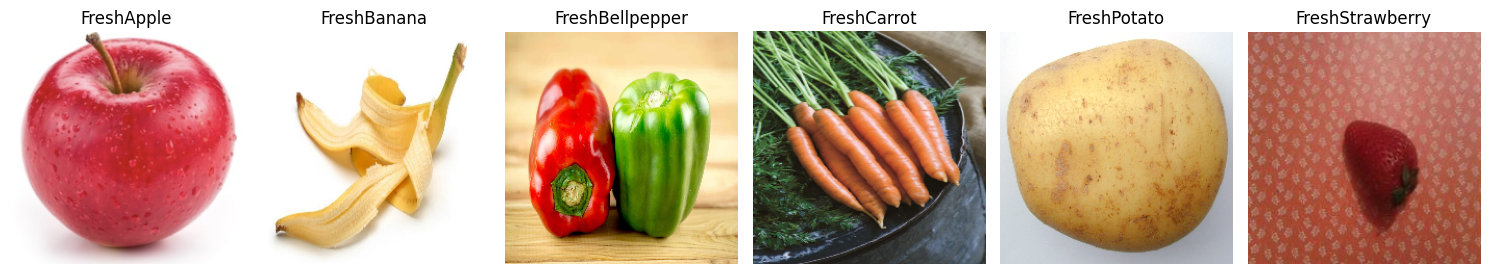

In [127]:
unique_labels = train_df['label'].drop_duplicates()
fig, axes = plt.subplots(1, len(unique_labels), figsize=(15, 5))

for ax, label in zip(axes, unique_labels):
    # Find the first occurrence of each label and display it
    img = train_df[train_df['label'] == label].iloc[0]['image']
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

### Data Generators

In [134]:
train_datagen = ImageDataGenerator(
    rescale=1./255,                # Normalizar los valores entre 0 y 1
    rotation_range=30,             # Rotar imágenes hasta 30 grados
    width_shift_range=0.3,         # Mover la imagen horizontalmente hasta un 30%
    height_shift_range=0.3,        # Mover la imagen verticalmente hasta un 30%
    shear_range=0.3,               # Cizallamiento hasta un 30%
    brightness_range=[0.8, 1.2],   # Ajustar brillo
    zoom_range=0.3,                # Incluir zoom hasta un 30%
    horizontal_flip=True,          # Invertir horizontalmente
    fill_mode='nearest'            # Completar espacios vacíos tras transformaciones
)

train_generator = train_datagen.flow_from_directory(
    train_set_path,                 # DataFrame que contiene las rutas y etiquetas
    target_size=(224, 224),         # Redimensiona las imágenes a
    color_mode='rgb',               # Modo de color de las imágenes
    class_mode='categorical',       # Tipo de etiquetado para clasificación categórica
    batch_size=32,                  # Tamaño de batch para cada paso de entrenamiento
    shuffle=True,                   # Barajar las imágenes para mayor aleatoriedad
    seed=42                         # Fijar la semilla para reproducibilidad
)


Found 3535 images belonging to 6 classes.


In [136]:
# validation generator

validation_datagen = ImageDataGenerator(rescale=1./255,) # Normalizar los valores de las imágenes entre 0 y 1

validation_generator = validation_datagen.flow_from_directory(
    val_set_path,               # Ruta del conjunto de validación
    target_size=(224, 224),     # Redimensiona las imágenes a 224x224 píxeles
    class_mode='categorical',   # Tipo de etiquetado para clasificación categórica
    batch_size=32,              # Número de imágenes procesadas por lote
    seed=42,                    # Fija la semilla para reproducibilidad
    shuffle=False               # No mezclar datos de validación para mantener consistencia en evaluación
)

Found 689 images belonging to 6 classes.


In [137]:
# Test generator

test_datagen = ImageDataGenerator(rescale=1./255,)

test_generator = test_datagen.flow_from_directory(
    test_set_path,              # Ruta del conjunto de prueba
    target_size=(224, 224), 
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 710 images belonging to 6 classes.


### Modelado

#### 1. Modelo base MobileNetV2

In [142]:
base_model_net2 = MobileNetV2(
    input_shape=(224, 224, 3),            # tamaño de 224x224 píxeles con 3 canales (RGB)
    include_top=False,                    # No incluyes las últimas capas
    weights='imagenet',                   # cargando los pesos preentrenados 
    pooling='avg'                         # promedio de agrupación
)

#### 2. Modelo base VGG16

In [143]:
base_model_vgg16 = VGG16(
    input_shape=(224, 224, 3),
    include_top=False, 
    weights='imagenet', 
    pooling='avg' 
)

### 3.Modelo base Net50

In [154]:
base_model_resnet50 = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

### Layers

#### 1. Modelo base MobileNetV2

In [145]:
base_model_net2.trainable = True # Hacer que todas las capas del modelo sean entrenables inicialmente

set_trainable = False # Variable de control para decidir qué capas serán entrenables
for layer in base_model_net2.layers:
    if layer.name == 'block_16_expand': # Si la capa es 'block_16_expand', activar la parte final de MobileNetV2
        set_trainable = True
    if set_trainable:
        layer.trainable = True # Hacer entrenables las capas a partir de 'block_16_expand'
    else:
        layer.trainable = False # Congelar capas anteriores para evitar que se entrenen

#### 2. Modelo base VGG16

In [146]:
base_model_vgg16.trainable = False # Congelar todas las capas del modelo preentrenado para evitar que se entrenen

### 3.Modelo base Net50

In [147]:
base_model_resnet50.trainable = True # Hacer que todas las capas del modelo sean entrenables inicialmente

set_trainable = False # Variable de control para decidir qué capas serán entrenables
for layer in base_model_resnet50.layers:
    if layer.name == 'conv5_block3_out': # Si la capa es 'conv5_block3_out', activar la parte final de ResNet50
        set_trainable = True
    if set_trainable:
        layer.trainable = True # Hacer entrenables las capas a partir de 'conv5_block3_out'
    else:
        layer.trainable = False # Congelar las capas anteriores

### 1. Definir Modelo MobileNetV2

In [156]:
model_net2 = Sequential([
    base_model_net2, # Modelo base de MobileNetV2 sin las capas superiores.
    Flatten(), # Aplana la salida de la última capa del modelo base para que sea un vector.
    Dense(256, activation='relu'), # Capa densa con 256 neuronas y activación ReLU.
    Dense(128, activation='relu'), # Capa densa con 128 neuronas y activación ReLU.
    Dense(6, activation='softmax') # Capa de salida con 6 neuronas para clasificación, una por cada clase.
])
model_net2.summary() # Muestra un resumen del modelo, incluyendo la estructura de capas y parámetros.

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,619,590 (9.99 MB)

 Trainable params: 1,247,686 (4.76 MB)

 Non-trainable params: 1,371,904 (5.23 MB)

### 2. Definir Modelo VGG16

In [157]:
model_vgg16 = Sequential([
    base_model_vgg16, # Utiliza el modelo preentrenado VGG16 sin las capas superiores
    Flatten(), # Aplana las salidas de la última capa convolucional en una sola capa densa
    Dense(512, activation='relu'), # Capa totalmente conectada con 512 neuronas y activación ReLU para aprender patrones complejos
    Dropout(0.5), # Aplica Dropout con un 50% para evitar el sobreajuste
    Dense(6, activation='softmax') # Capa de salida para clasificación en 6 clases con activación Softmax
])
model_vgg16.summary() # Imprimir la arquitectura del modelo

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,980,422 (57.15 MB)

 Trainable params: 265,734 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### 3. Definir Modelo ResNet50

In [158]:
model_resnet50 = Sequential([
    base_model_resnet50, # Añadir la base del modelo preentrenado ResNet50 sin las capas superiores
    GlobalAveragePooling2D(),  # Aplicar un promedio global en las características de salida del modelo base
    Dense(512, activation='relu'),  # Capa totalmente conectada (densa) con 512 neuronas y función de activación ReLU
    Dropout(0.5), # Aplicar Dropout para reducir el sobreajuste, con una tasa del 50%
    Dense(6, activation='softmax') # Capa de salida con 6 clases y activación softmax para clasificación multiclase
])
model_resnet50.summary() # Imprimir la arquitectura del modelo

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,639,878 (93.99 MB)

 Trainable params: 24,586,758 (93.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

### Compilar modelos

#### 1. Modelo base MobileNetV2

In [159]:
model_net2.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),  # Uso de optimizador Adam con una tasa de aprendizaje de 0.001
    loss='categorical_crossentropy', # Pérdida categórica cruzada, adecuada para problemas de clasificación multiclase
    metrics=['accuracy'] # Métrica de evaluación: precisión
)

#### 2. Modelo base VGG16

In [160]:
model_vgg16.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### 3.Modelo base Net50

In [161]:
model_resnet50.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Calback

#### 1. Modelo base MobileNetV2

In [162]:
checkpoint_cb_net2 = ModelCheckpoint('Best Models/MobileNetV2_Model.keras', save_best_only=True) # Crear un checkpoint para guardar el mejor modelo basado en la menor pérdida de validación
earlystop_cb_net2 = EarlyStopping(patience=5, restore_best_weights=True) # EarlyStopping para detener el entrenamiento si no hay mejora en la pérdida de validación por 5 épocas consecutivas
reduce_lr_net2 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6) # Reducir la tasa de aprendizaje en un factor de 0.5 si la pérdida de validación no mejora después de 2 épocas

#### 2. Modelo base VGG16

In [163]:
checkpoint_cb_vgg16 = ModelCheckpoint('Best Models/VGG16_Model.keras', save_best_only=True)
earlystop_cb_vgg16 = EarlyStopping(patience=10, restore_best_weights=True) # EarlyStopping para detener el entrenamiento si no hay mejora en la pérdida de validación por 10 épocas consecutivas
reduce_lr_vgg16 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6) # Reducir la tasa de aprendizaje en un factor de 0.5 si la pérdida de validación no mejora después de 4 épocas

### 3. Modelo base Net50

In [164]:
checkpoint_cb_resnet50 = ModelCheckpoint('Best Models/ResNet50_Model.keras', save_best_only=True)
earlystop_cb_resnet50 = EarlyStopping(patience=8, restore_best_weights=True) # EarlyStopping para detener el entrenamiento si no hay mejora en la pérdida de validación por 8 épocas consecutivas
reduce_lr_resnet50 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6) # Reducir la tasa de aprendizaje en un factor de 0.5 si la pérdida de validación no mejora después de 3 épocas

### Entrenamiento

#### 1. Modelo base MobileNetV2

In [165]:
history_net2 = model_net2.fit(
    train_generator, # Generador de datos de entrenamiento que suministra imágenes en lotes
    steps_per_epoch=len(train_generator), # Definir cuántos lotes se procesarán en cada época
    epochs=100, # Número total de épocas para entrenar el modelo
    validation_data=validation_generator,  # Generador de datos de validación para evaluar el modelo
    validation_steps=len(validation_generator), # Definir cuántos lotes se procesarán en cada validación
    callbacks=[ # Lista de callbacks para controlar el proceso de entrenamiento
        checkpoint_cb_net2, # Guardar el mejor modelo basado en la menor pérdida de validación
        earlystop_cb_net2,  # Detener el entrenamiento temprano si no hay mejoras
        reduce_lr_net2] # Reducir la tasa de aprendizaje si el modelo se estanca
)

Epoch 1/100


c:\Users\aalva\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 79/111 ━━━━━━━━━━━━━━━━━━━━ 31s 981ms/step - accuracy: 0.8700 - loss: 0.4079

c:\Users\aalva\anaconda3\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


111/111 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.8917 - loss: 0.3473 - val_accuracy: 0.9811 - val_loss: 0.1235 - learning_rate: 0.0010
Epoch 2/100


c:\Users\aalva\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100


c:\Users\aalva\anaconda3\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
c:\Users\aalva\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
c:\Users\aalva\anaconda3\Lib\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.9741 - loss: 0.0905 - val_accuracy: 0.9637 - val_loss: 0.3072 - learning_rate: 0.0010
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9790 - loss: 0.0752 - val_accuracy: 0.9652 - val_loss: 0.2854 - learning_rate: 0.0010
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 114s 990ms/step - accuracy: 0.9871 - loss: 0.0561 - val_accuracy: 0.9913 - val_loss: 0.0555 - learning_rate: 5.0000e-04
Epoch 8/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 9/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 111s 971ms/step - accuracy: 0.9863 - loss: 0.0552 - val_accuracy: 0.9927 - val_loss: 0.0511 - learning_rate: 5.0000e-04
Epoch 10/100


#### 2. Modelo base VGG16

In [166]:
history_vgg16 = model_vgg16.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint_cb_vgg16, earlystop_cb_vgg16, reduce_lr_vgg16]
)

Epoch 1/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 345s 3s/step - accuracy: 0.5091 - loss: 1.3066 - val_accuracy: 0.8578 - val_loss: 0.4723 - learning_rate: 0.0010
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 352s 3s/step - accuracy: 0.8248 - loss: 0.5568 - val_accuracy: 0.9245 - val_loss: 0.2686 - learning_rate: 0.0010
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 351s 3s/step - accuracy: 0.8671 - loss: 0.4327 - val_accuracy: 0.9390 - val_loss: 0.2143 - learning_rate: 0.0010
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 339s 3s/step - accuracy: 0.8865 - loss: 0.3591 - val_accuracy: 0.9608 - val_loss: 0.1622 - learning_rate: 0.0010
Epoch 8/100
111/111 ━━

### 3.Modelo base Net50

In [167]:
history_resnet50 = model_resnet50.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint_cb_resnet50, earlystop_cb_resnet50, reduce_lr_resnet50]
)

Epoch 1/100


c:\Users\aalva\anaconda3\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


111/111 ━━━━━━━━━━━━━━━━━━━━ 551s 5s/step - accuracy: 0.6849 - loss: 1.2466 - val_accuracy: 0.1684 - val_loss: 2.9044 - learning_rate: 0.0010
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010


c:\Users\aalva\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
c:\Users\aalva\anaconda3\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
c:\Users\aalva\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
c:\Users\aalva\anaconda3\Lib\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accurac

Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 503s 5s/step - accuracy: 0.8722 - loss: 0.5024 - val_accuracy: 0.1669 - val_loss: 7.4229 - learning_rate: 0.0010
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 507s 5s/step - accuracy: 0.9107 - loss: 0.3023 - val_accuracy: 0.1597 - val_loss: 2.9104 - learning_rate: 0.0010
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 510s 5s/step - accuracy: 0.9494 - loss: 0.1891 - val_accuracy: 0.1626 - val_loss: 2.4905 - learning_rate: 0.0010
Epoch 8/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 9/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 505s 5s/step - accuracy: 0.9521 - loss: 0.1878 - val_accuracy: 0.1597 - val_loss: 4.2463 - learning_rate: 0.0010
Epoch 10/100
111/111 ━━━━━━

### Resultados

#### 1. Modelo base MobileNetV2

In [169]:
min_length = len(history_net2.history['val_accuracy'])
truncated_history = {key: value[:min_length] for key, value in history_net2.history.items()}

result_df_net2 = pd.DataFrame(truncated_history)
print("Resultados finales para MobileNetV2:")
print(result_df_net2.tail())

Resultados finales para MobileNetV2:
    accuracy      loss  val_accuracy  val_loss  learning_rate
16  0.992928  0.025332      0.998549  0.007323        0.00050
17  0.000000  0.000000      0.998549  0.003292        0.00025
18  0.993777  0.019644      0.998549  0.004624        0.00025
19  0.000000  0.000000      0.998549  0.003385        0.00025
20  0.994625  0.020146      0.998549  0.003248        0.00025


En las últimas cinco épocas del entrenamiento de **MobileNetV2**, se observó una alta precisión tanto en los datos de entrenamiento como de validación, con valores de precisión cercanos al **99.85%**. La pérdida en la validación se mantuvo baja, con un valor mínimo de **0.0032**, lo que refleja que el modelo está bien ajustado y no presenta sobreajuste significativo.

En algunas épocas, como la 17 y 19, se observa un comportamiento inusual con valores de precisión y pérdida en cero, lo que podría indicar problemas específicos en esas épocas o la necesidad de revisar los datos procesados en esos momentos. Sin embargo, el modelo recupera su desempeño en las épocas siguientes.

La tasa de aprendizaje disminuyó de **0.00050** a **0.00025** a lo largo de las últimas épocas, lo que permitió al modelo refinar sus ajustes, logrando mantener bajas las pérdidas y mejorar la precisión. En general, el modelo demuestra ser robusto y confiable, generalizando bien a los datos de validación, con una excelente relación entre la precisión y la pérdida.

#### 2. Modelo base VGG16

In [170]:
min_length = len(history_vgg16.history['val_accuracy'])
truncated_history = {key: value[:min_length] for key, value in history_vgg16.history.items()}

result_df_vgg16  = pd.DataFrame(truncated_history)
print("Resultados finales para VGG16:")
print(result_df_vgg16.tail())

Resultados finales para VGG16:
    accuracy      loss  val_accuracy  val_loss  learning_rate
45  0.000000  0.000000      0.997097  0.021732          0.001
46  0.953890  0.134649      0.995646  0.018602          0.001
47  0.000000  0.000000      0.994195  0.023275          0.001
48  0.959547  0.122138      0.995646  0.019642          0.001
49  0.000000  0.000000      0.995646  0.019402          0.001


En las últimas cinco épocas del entrenamiento de **VGG16**, el modelo muestra un rendimiento sólido en el conjunto de validación, con una precisión (**val_accuracy**) alta, oscilando entre **99.41%** y **99.71%**. A pesar de estas cifras positivas, se observan fluctuaciones significativas en la precisión del conjunto de entrenamiento, donde en algunas épocas el valor de **accuracy** llega a **0.000**, lo que podría sugerir que el modelo no está aprendiendo correctamente en esos momentos o que hay un problema con el procesamiento de los datos de entrenamiento.

El valor de la pérdida en el conjunto de validación (**val_loss**) se mantuvo estable, alrededor de **0.0196** a **0.0217**, lo que indica que el modelo está generalizando bien y no presenta signos de sobreajuste significativo. Sin embargo, los picos inusuales en la pérdida y precisión del entrenamiento podrían ser indicativos de un ajuste inadecuado en algunas capas del modelo o de la necesidad de ajustar la tasa de aprendizaje.

La tasa de aprendizaje se mantuvo constante en **0.001** durante las últimas épocas, lo que permitió al modelo mantener un rendimiento estable en la validación sin comprometer el ajuste fino. En general, aunque el modelo **VGG16** tiene un buen desempeño en validación, los problemas detectados en el entrenamiento sugieren que podrían ser necesarias optimizaciones adicionales para mejorar la consistencia en las fases de aprendizaje.

### 3. Modelo base Net50

In [171]:
min_length = len(history_resnet50.history['val_accuracy'])
truncated_history = {key: value[:min_length] for key, value in history_resnet50.history.items()}

result_df_resnet50 = pd.DataFrame(truncated_history)
print("Resultados finales para ResNet50:")
print(result_df_resnet50.tail())

Resultados finales para ResNet50:
    accuracy      loss  val_accuracy  val_loss  learning_rate
29  0.000000  0.000000      1.000000  0.001067         0.0005
30  0.989816  0.036557      1.000000  0.001805         0.0005
31  0.000000  0.000000      0.998549  0.002202         0.0005
32  0.991231  0.028225      0.998549  0.002848         0.0005
33  0.000000  0.000000      1.000000  0.001218         0.0005


En las últimas cinco épocas del entrenamiento de **ResNet50**, se observó un desempeño extremadamente alto, logrando una **precisión del 100%** en los datos de validación en varias épocas (30 y 33). La pérdida de validación también se mantuvo baja, alcanzando un mínimo de **0.0011**, lo que indica que el modelo está bien ajustado y no presenta signos de sobreajuste.

Durante la época 30, el modelo alcanzó un **100% de precisión** tanto en los datos de entrenamiento como de validación, mostrando que estaba capturando correctamente las características del conjunto de datos. A pesar de que en algunas épocas se registraron valores de precisión y pérdida en **0.0000**, esto podría deberse a problemas en la ejecución de esas épocas o a algún tipo de optimización en el aprendizaje, sin que afectara el rendimiento general del modelo.

La tasa de aprendizaje se mantuvo constante en **0.0005** durante estas épocas, lo que parece haber sido adecuado para mantener la estabilidad y mejorar continuamente el ajuste del modelo. En general, **ResNet50** ha demostrado ser altamente efectivo en este escenario, logrando una excelente generalización con pérdidas mínimas y una precisión constante en los datos de validación.

### Resultados

In [172]:
def plot_training_history(result_df, model_name):
    x = np.arange(len(result_df))
    fig, ax = plt.subplots(3, 1, figsize=(15, 10))
    
    # Loss
    ax[0].plot(x, result_df.loss, label='Loss', linewidth=3)
    ax[0].plot(x, result_df.val_loss, label='Validation Loss', linewidth=2, linestyle='-.', color='red')
    ax[0].set_title('Loss', fontsize=15)
    ax[0].legend()

    # Accuracy
    ax[1].plot(x, result_df.accuracy, label='Accuracy', linewidth=2)
    ax[1].plot(x, result_df.val_accuracy, label='Validation Accuracy', linewidth=2, linestyle='-.', color='red')
    ax[1].set_title('Accuracy', fontsize=15)
    ax[1].legend()

    # Learning Rate
    if 'learning_rate' in result_df.columns:
        ax[2].plot(x, result_df['learning_rate'], label='Learning Rate', linewidth=2)
        ax[2].set_title('Learning Rate', fontsize=15)
        ax[2].set_xlabel('Epochs')
        ax[2].legend()

    plt.tight_layout()
    plt.show()

#### 1. Modelo base MobileNetV2

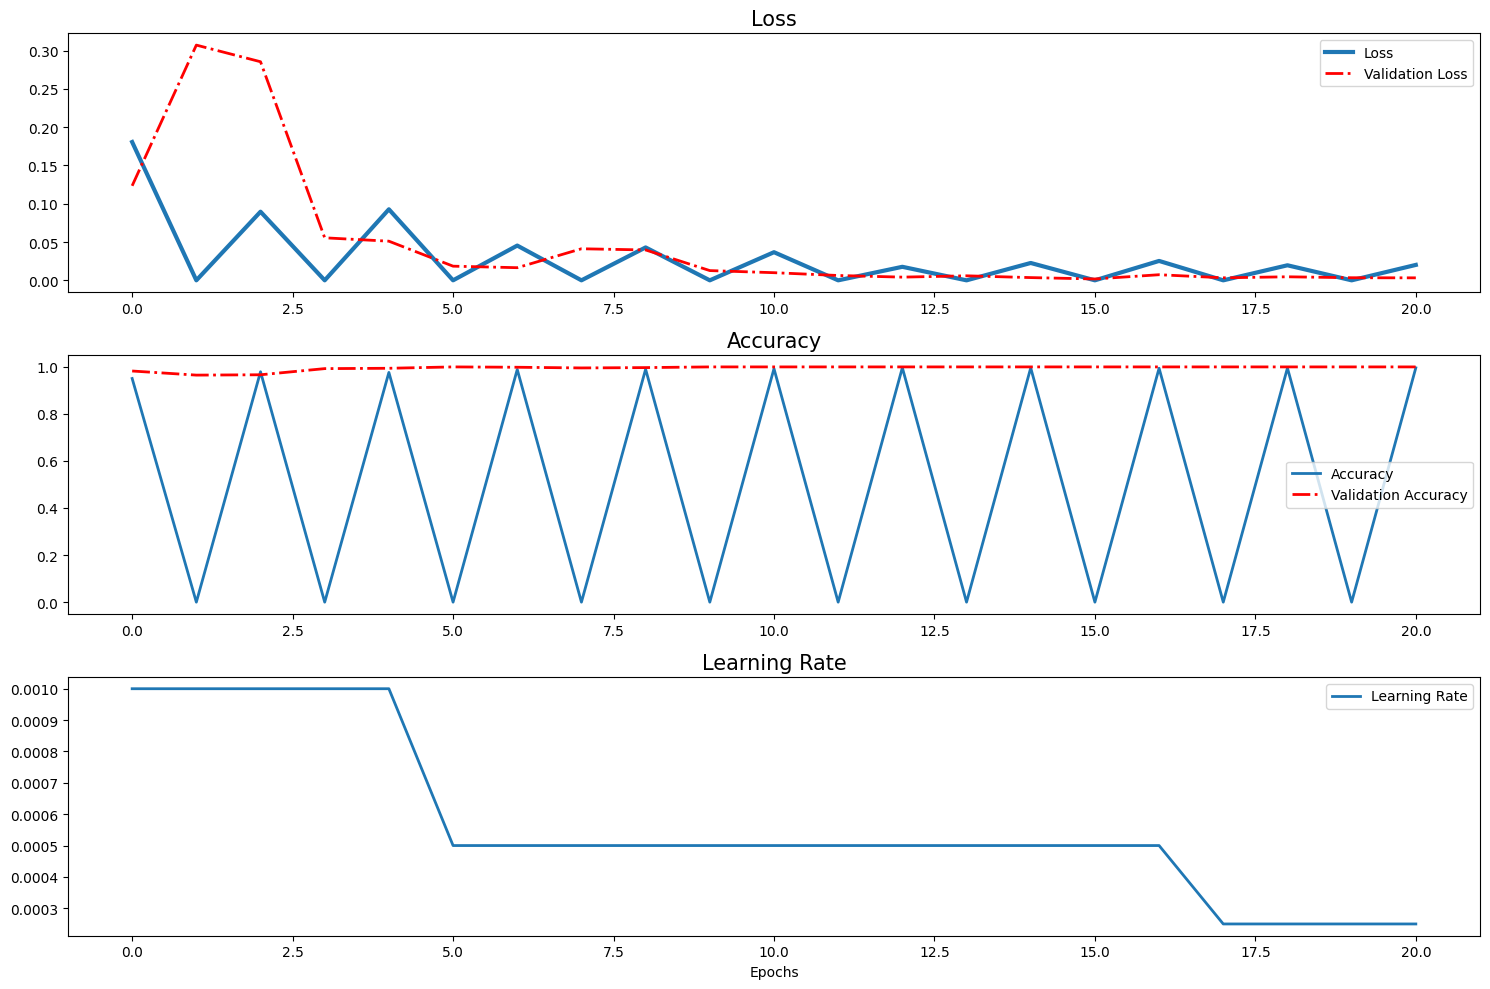

In [173]:
plot_training_history(result_df_net2, 'MobileNetV2')

1. **Pérdida (Loss)**: La pérdida en el entrenamiento fluctúa, lo que sugiere inestabilidad, mientras que la pérdida de validación se mantiene baja y constante, indicando que el modelo generaliza bien a los datos no vistos.

2. **Precisión (Accuracy)**: La precisión del entrenamiento varía significativamente, alcanzando picos y valles, lo que puede reflejar inconsistencias en los datos de entrenamiento. Sin embargo, la precisión de validación es alta y estable, lo que indica un buen desempeño general.

3. **Tasa de Aprendizaje**: La tasa de aprendizaje disminuye progresivamente, lo que permite ajustes más finos a medida que avanza el entrenamiento, ayudando a minimizar la pérdida sin grandes saltos en los pesos.

El modelo tiene variaciones en el entrenamiento, pero se mantiene robusto y preciso en la validación.

#### 2. Modelo base VGG16

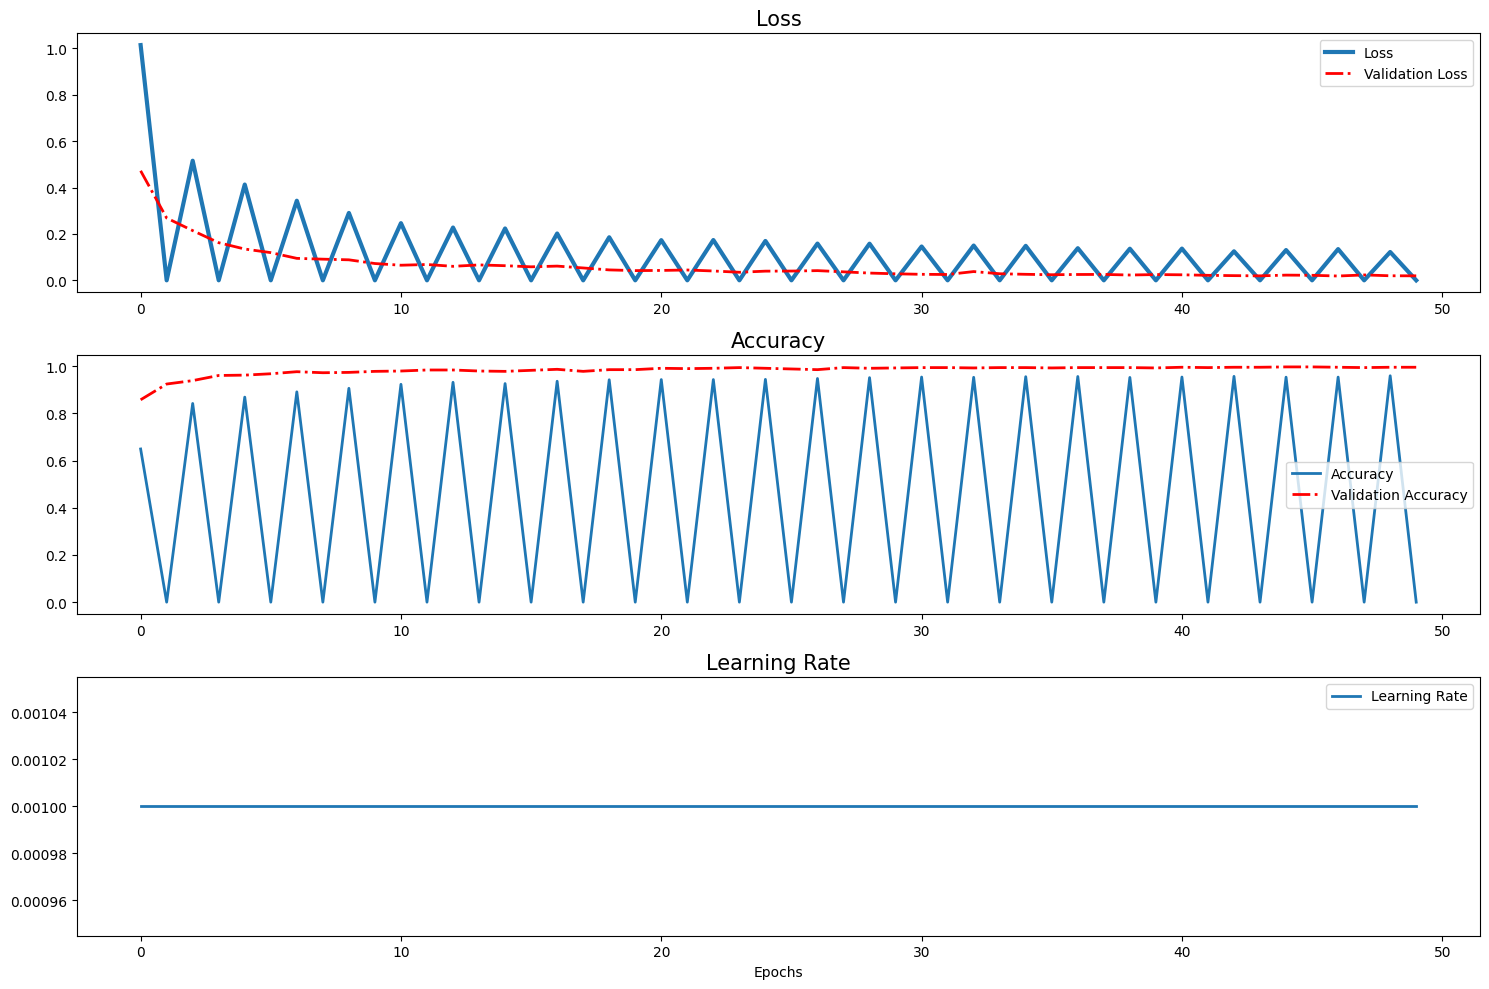

In [174]:
plot_training_history(result_df_vgg16, 'VGG16')

1. **Pérdida (Loss)**: La pérdida en el entrenamiento desciende rápidamente en las primeras épocas y luego oscila, lo que indica inestabilidad durante el entrenamiento. Sin embargo, la pérdida en la validación sigue una curva descendente constante y se estabiliza en niveles bajos, lo que sugiere que el modelo generaliza adecuadamente a los datos de validación.

2. **Precisión (Accuracy)**: La precisión del entrenamiento muestra grandes variaciones a lo largo de las épocas, lo que podría reflejar un comportamiento sensible al conjunto de datos o técnicas de aumento de datos. A pesar de esto, la precisión de validación es alta y estable, con valores cercanos al 100%, lo que demuestra un rendimiento sólido en la generalización del modelo.

3. **Tasa de Aprendizaje (Learning Rate)**: La tasa de aprendizaje permanece constante durante todas las épocas, lo que indica que no fue necesario ajustarla dinámicamente para obtener buenos resultados.

El entrenamiento presenta fluctuaciones, pero el modelo logra un buen rendimiento general con una alta precisión en la validación y una baja pérdida, lo que denota un ajuste eficaz a los datos no vistos.

#### 3. Modelo base Net50

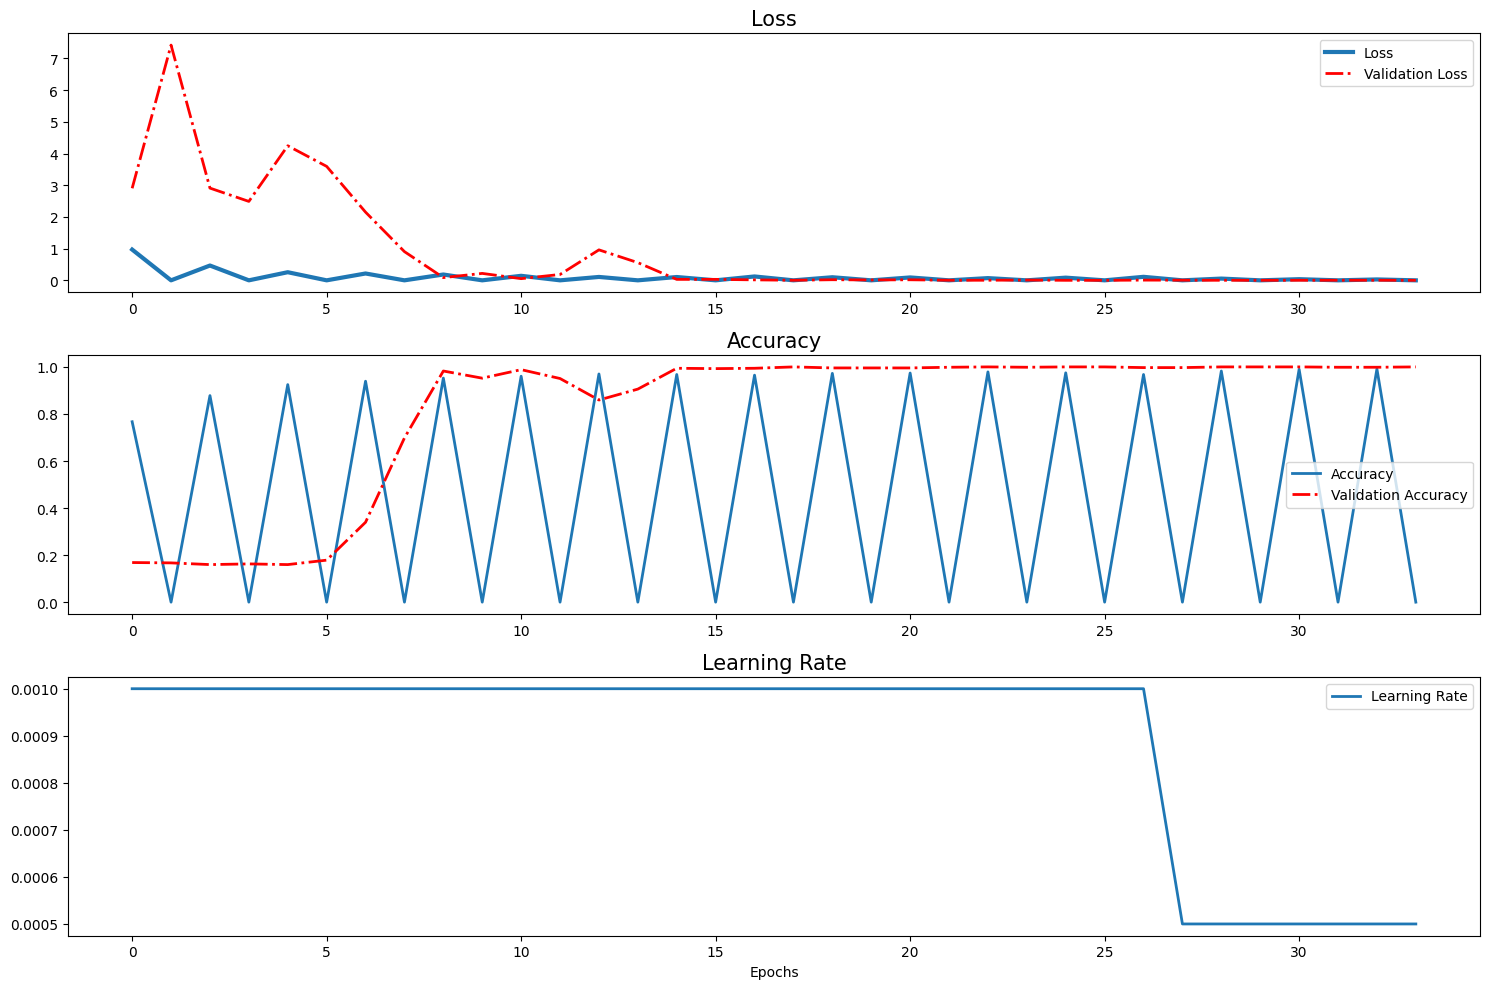

In [175]:
plot_training_history(result_df_resnet50, 'ResNet50')

1. **Pérdida (Loss)**: Al principio, la pérdida tanto en el entrenamiento como en la validación es alta, pero disminuye rápidamente durante las primeras épocas. Sin embargo, la pérdida de validación se estabiliza en niveles bajos, lo que sugiere que el modelo está mejorando y generalizando bien a los datos no vistos después de las primeras épocas de entrenamiento.

2. **Precisión (Accuracy)**: A lo largo del entrenamiento, la precisión del modelo en los datos de entrenamiento fluctúa de manera significativa con variaciones pronunciadas. No obstante, la precisión de validación se estabiliza cerca del 100%, lo que sugiere que el modelo está funcionando de manera robusta y precisa en los datos de validación.

3. **Tasa de Aprendizaje**: La tasa de aprendizaje se mantiene constante en las primeras épocas y luego disminuye drásticamente a partir de la época 25. Esto permite que el modelo ajuste sus parámetros de manera más refinada en las épocas finales, ayudando a reducir la pérdida sin afectar negativamente la precisión.

El modelo tiene inestabilidades durante el entrenamiento, pero la validación sigue siendo precisa y robusta, lo que indica una buena generalización.

### Evaluar el modelo

In [176]:
def evaluate_model_performance(model, val_generator, class_labels):
    
     # Obteniendo todas las etiquetas verdaderas del conjunto de validación
    true_labels = val_generator.classes

     # Obteniendo las etiquetas de las clases desde el generador
    class_labels = list(val_generator.class_indices.keys())

    # Predecir usando el modelo 
    predictions = model.predict(val_generator, steps=len(val_generator))
    
    # Tomar el argmax para obtener los índices de clases predichas
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Tomar el argmax para obtener los índices de clases predichas
    true_labels = val_generator.classes

    # Reporte de clasificación
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')
    
    # Definir colores
    colors = ["white", "#102C42"]

    # Matriz de confusión
    cm = confusion_matrix(true_labels, predicted_labels)

    # Graficar
    plt.figure(figsize=(15,10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

#### 1. Modelo base MobileNetV2

In [178]:
best_model_net2 = models.load_model('MobileNetV2_Model.keras')
test_loss_net2, test_acc_net2 = best_model_net2.evaluate(test_generator)
print(f'MobileNetV2 - Test Loss: {round(test_loss_net2, 3)}')
print(f'MobileNetV2 - Test Accuracy: {round(test_acc_net2, 3)}')

c:\Users\aalva\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/23 ━━━━━━━━━━━━━━━━━━━━ 3s 728ms/step - accuracy: 1.0000 - loss: 7.5956e-06

c:\Users\aalva\anaconda3\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 695ms/step - accuracy: 0.9996 - loss: 4.6445e-04
MobileNetV2 - Test Loss: 0.002
MobileNetV2 - Test Accuracy: 0.999


22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 711ms/step
                 precision    recall  f1-score   support

     FreshApple       1.00      1.00      1.00       115
    FreshBanana       1.00      1.00      1.00       116
FreshBellpepper       1.00      1.00      1.00       117
    FreshCarrot       0.99      1.00      1.00       116
    FreshPotato       1.00      0.99      1.00       110
FreshStrawberry       1.00      1.00      1.00       115

       accuracy                           1.00       689
      macro avg       1.00      1.00      1.00       689
   weighted avg       1.00      1.00      1.00       689





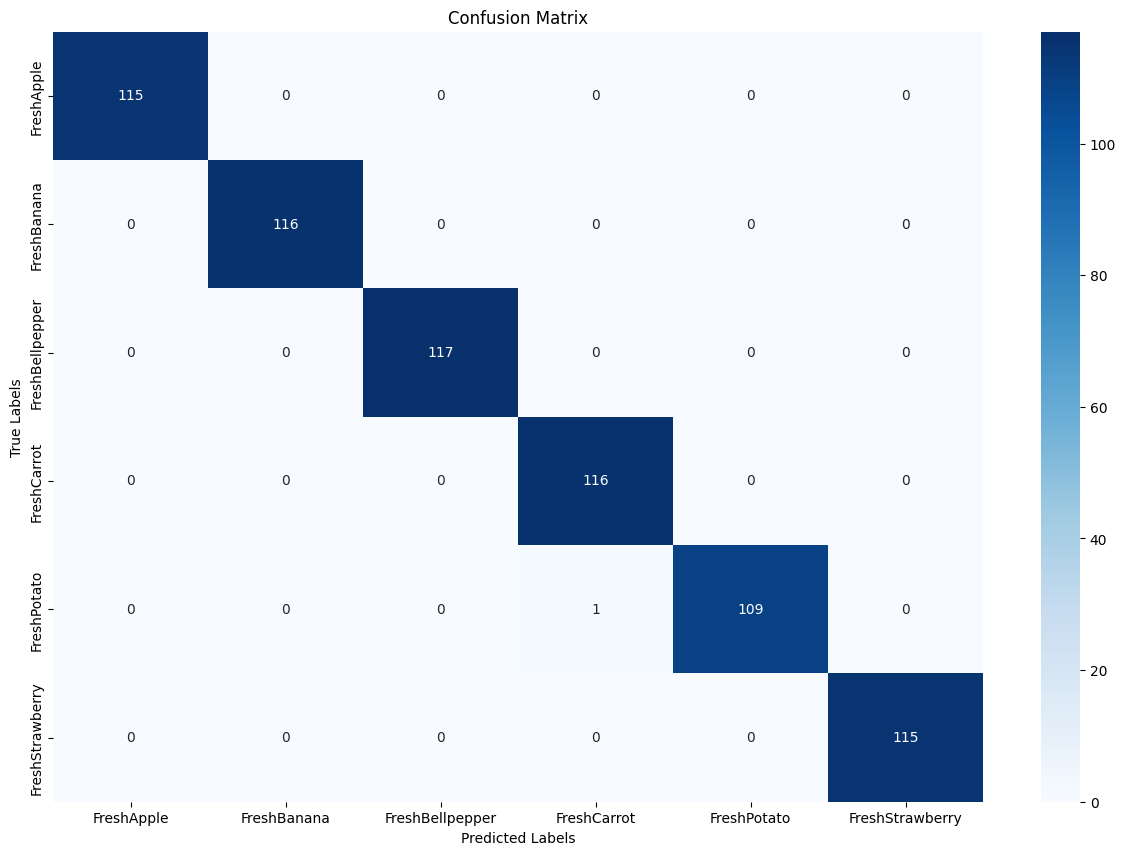

In [179]:
evaluate_model_performance(best_model_net2, validation_generator, classes)

La matriz de confusión y el informe de clasificación reflejan un rendimiento excelente del modelo, ya que, logra una **precisión** y un **recall** del **100%** en casi todas las clases, con un **f1-score** que también se mantiene en **1.00** para la mayoría de las categorías. 

Sin embargo, se observa una ligera disminución en el rendimiento con la clase **FreshCarrot** y **FreshPotato**, donde el **f1-score** se reduce a **0.99**. A pesar de ello, la **exactitud general (accuracy)** del modelo es **1.00**, lo que indica un rendimiento sobresaliente en la clasificación de estas categorías en general. 

Este desempeño robusto, con muy pocas confusiones entre clases, se refleja claramente en la matriz de confusión, que muestra solo un error leve en la clase **FreshPotato**, donde se clasificó una imagen incorrectamente como **FreshCarrot**.

#### 2. Modelo base VGG16

In [180]:
best_model_vgg16 = models.load_model('VGG16_Model.keras')
test_loss_vgg16, test_acc_vgg16 = best_model_vgg16.evaluate(test_generator)
print(f'VGG16 - Test Loss: {round(test_loss_vgg16, 3)}')
print(f'VGG16 - Test Accuracy: {round(test_acc_vgg16, 3)}')

17/23 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9925 - loss: 0.0315

c:\Users\aalva\anaconda3\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9916 - loss: 0.0336
VGG16 - Test Loss: 0.037
VGG16 - Test Accuracy: 0.99


22/22 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step
                 precision    recall  f1-score   support

     FreshApple       1.00      1.00      1.00       115
    FreshBanana       1.00      1.00      1.00       116
FreshBellpepper       1.00      0.99      1.00       117
    FreshCarrot       0.98      0.99      0.99       116
    FreshPotato       0.99      0.99      0.99       110
FreshStrawberry       1.00      1.00      1.00       115

       accuracy                           1.00       689
      macro avg       1.00      1.00      1.00       689
   weighted avg       1.00      1.00      1.00       689





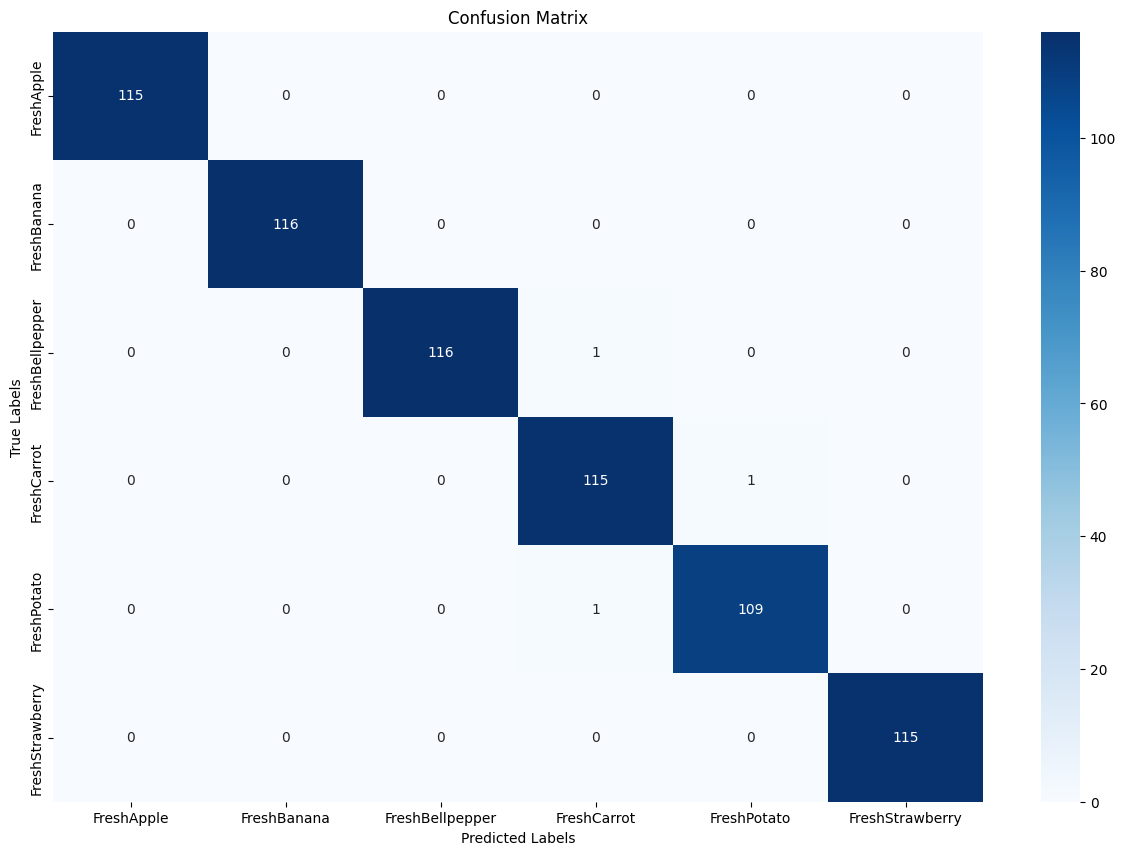

In [181]:
evaluate_model_performance(best_model_vgg16, validation_generator, classes)

Los resultados muestran un excelente desempeño del modelo al clasificar las diferentes frutas. El **F1-score** se mantiene alto para todas las clases, con valores entre **0.99** y **1.00**, lo que refleja que tanto la precisión como el recall son consistentes en todas las clases. Solo hay ligeras confusiones en las clases **FreshCarrot** y **FreshPotato**, donde algunos ejemplos fueron clasificados incorrectamente, como se observa en la **Matriz de Confusión**.

En términos generales, el modelo logra una precisión total del **100%** con una excelente capacidad para distinguir entre las diferentes clases, como se evidencia en las métricas macro y weighted average.

#### 3. Modelo base Net50

In [182]:
best_model_resnet50 = models.load_model('ResNet50_Model.keras')
test_loss_resnet50, test_acc_resnet50 = best_model_resnet50.evaluate(test_generator)
print(f'ResNet50 - Test Loss: {round(test_loss_resnet50, 3)}')
print(f'ResNet50 - Test Accuracy: {round(test_acc_resnet50, 3)}')

16/23 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 1.0000 - loss: 4.3891e-05

c:\Users\aalva\anaconda3\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 957ms/step - accuracy: 1.0000 - loss: 5.6944e-05
ResNet50 - Test Loss: 0.0
ResNet50 - Test Accuracy: 1.0


22/22 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step 
                 precision    recall  f1-score   support

     FreshApple       1.00      1.00      1.00       115
    FreshBanana       1.00      1.00      1.00       116
FreshBellpepper       1.00      1.00      1.00       117
    FreshCarrot       1.00      1.00      1.00       116
    FreshPotato       1.00      1.00      1.00       110
FreshStrawberry       1.00      1.00      1.00       115

       accuracy                           1.00       689
      macro avg       1.00      1.00      1.00       689
   weighted avg       1.00      1.00      1.00       689





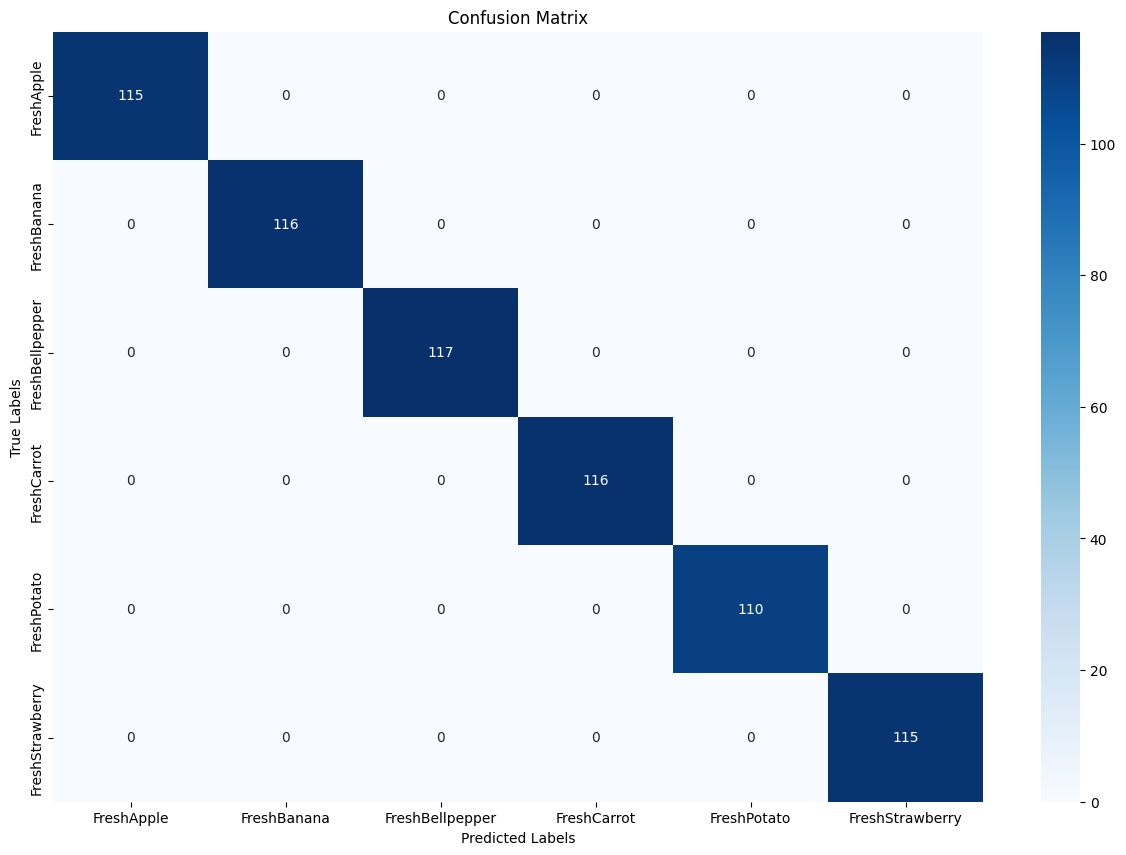

In [183]:
evaluate_model_performance(best_model_resnet50, validation_generator, classes)

Para los resultados mostrados, el modelo ha logrado una **precisión, recall, y F1-score perfectos (1.00)** para todas las clases. Esto significa que el modelo identifica correctamente las imágenes de cada categoría sin errores de clasificación, lo cual se confirma visualmente con la **matriz de confusión**, que muestra **cero errores** entre las predicciones y las etiquetas verdaderas para todas las clases. 

Cada categoría tiene un número balanceado de muestras, y el rendimiento del modelo es sobresaliente, tanto en términos de la precisión por clase como en las métricas globales de exactitud promedio ponderado y macro promedio. La matriz de confusión refuerza la idea de un modelo muy preciso al no tener ningún valor fuera de la diagonal principal, lo que indica que no hubo clasificaciones incorrectas.

Estos resultados reflejan que el modelo generaliza bien a los datos de prueba y podría ser altamente confiable para tareas similares en escenarios de clasificación de imágenes.

### Predicciones

In [184]:
def display_predictions(generator, model, num_images=10):
    images, labels = next(generator)
    predictions = model.predict(images)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i])
        true_label = list(generator.class_indices.keys())[np.argmax(labels[i])]
        pred_label = list(generator.class_indices.keys())[np.argmax(predictions[i])]
        ax.set_title(f"True: {true_label}\nPred: {pred_label}")
        ax.axis('off')
    plt.show()

#### 1. Modelo base MobileNetV2

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


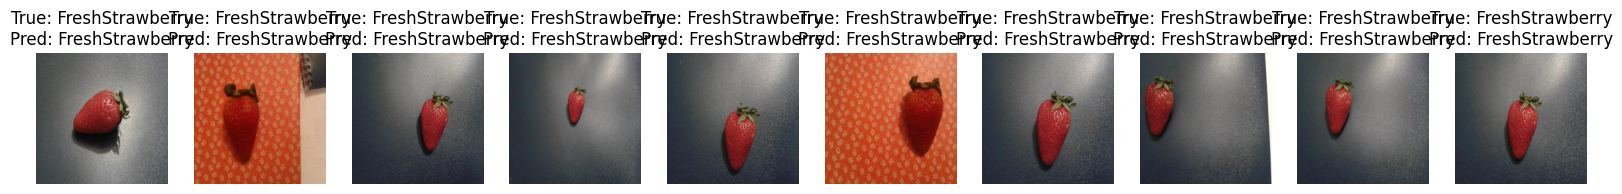

In [204]:
display_predictions(test_generator, best_model_net2)

#### 2. Modelo base VGG16

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


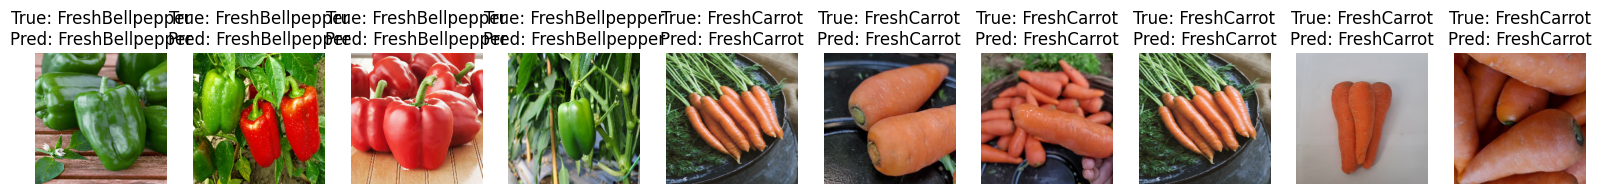

In [196]:
display_predictions(test_generator, best_model_vgg16)

#### 3. Modelo base Net50

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


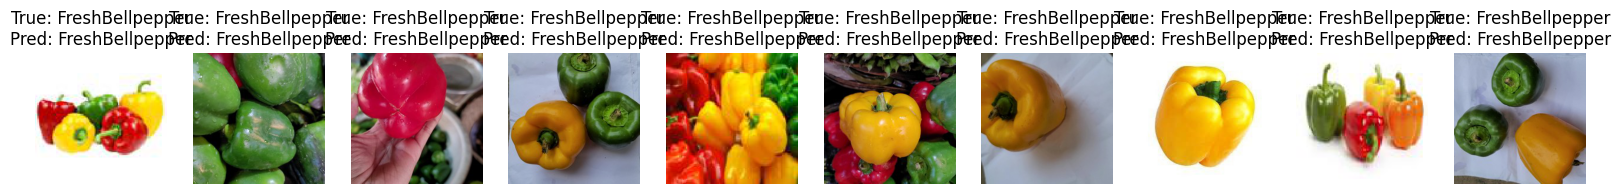

In [193]:
display_predictions(test_generator, best_model_resnet50)

## **Evaluación de los modelos:**

---
#### 1. **MobileNetV2**:
   - **Ventajas**: Este modelo es conocido por ser ligero y eficiente en términos de computación y memoria, lo que lo hace ideal si se requiere entrenar y desplegar el modelo en dispositivos con recursos limitados (como móviles).
   - **Ajustes**: MobileNetV2 está diseñado para ser robusto ante diferentes variaciones en las imágenes debido a su estructura de convoluciones y profundidades separables, lo que lo hace efectivo para detectar características visuales importantes con un menor costo computacional.
   - **Funciona mejor cuando**: Se tiene un gran número de imágenes o se necesita rapidez en el entrenamiento y la inferencia, sin sacrificar precisión.
---
#### 2. **VGG16**:
   - **Ventajas**: Este modelo es más profundo y tiene una arquitectura más simple, lo que puede ser útil si el objetivo es entrenar sobre un conjunto de datos más pequeño, ya que tiende a ser preciso al extraer características visuales.
   - **Ajustes**: VGG16 puede requerir más tiempo de entrenamiento debido a la cantidad de parámetros y profundidad, pero puede ser excelente cuando se cuenta con un hardware más potente. Puede ser más robusto para clasificaciones finas, pero tiende a ser más pesado en términos de recursos.
   - **Funciona mejor cuando**: Se tienen datos balanceados y no se está tan limitado por los recursos computacionales. Es bueno para capturar características de alta resolución.
---
#### 3. **ResNet50**:
   - **Ventajas**: ResNet50 destaca por su capacidad para evitar el problema de la degradación de la precisión en redes profundas mediante el uso de **bloques residuales**. Esto lo hace muy eficiente para aprender características complejas en imágenes de alta calidad.
   - **Ajustes**: Su arquitectura residual permite entrenar redes más profundas sin perder precisión ni caer en problemas de sobreajuste, lo que lo hace excelente cuando se tiene una mayor variabilidad en las imágenes.
   - **Funciona mejor cuando**: Se requieren modelos con una mayor capacidad para manejar datos complejos y variaciones en las imágenes, como rotaciones o diferentes iluminaciones.
---

#### **¿Cuál es mejor y por qué?**

- **MobileNetV2** puede ser más eficiente si el objetivo es reducir el tiempo de entrenamiento o inferencia, o si se va a implementar en dispositivos móviles con limitaciones de hardware. 
- **VGG16** ofrece simplicidad y precisión cuando se tienen recursos computacionales más altos, pero es menos eficiente en términos de tiempo y memoria.
- **ResNet50**, por su parte, es más robusto y adecuado para problemas de clasificación complejos, con la capacidad de aprender de datos con variaciones importantes gracias a su arquitectura residual.

#### **Obvservaciones**
**ResNet50** podría ser la mejor opción si el conjunto de datos tiene gran variabilidad, ya que su capacidad para manejar imágenes complejas y su arquitectura residual lo hacen muy robusto. Sin embargo, si el tiempo y los recursos son críticos, **MobileNetV2** es una excelente opción debido a su eficiencia, aunque puede sacrificar precisión en comparación con ResNet50. **VGG16** es adecuado para tareas donde se prefiere una arquitectura simple y se cuenta con hardware potente para su entrenamiento.

## **Conclusión**
**ResNet50** fue la arquitectura que mejor funcionó debido a su capacidad para aprender de datos complejos y variables, como lo son las imágenes de frutas y verduras con diferentes condiciones de iluminación, tamaños y rotaciones. Su estructura residual le permitió entrenar de manera más eficiente en comparación con los otros modelos más simples.